In [1]:
# Generic stuff
import time
import os, sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d
from copy import deepcopy

import torch
from sbi import utils as utils
from sbi.inference.base import infer
from sbi import analysis as analysis

    
# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt

# CTWC model code
sys.path.append('../ctwc')

from ctwc_model_DP import run_net_sim

filename = "samples_fit_Gs.npy"

N_RUNS = 3
N_SIMULATIONS = 5
N_SAMPLES = 1000
Gs = np.arange(0.0, 2.1, 0.5)

T = 2**12
dt = 0.1


In [2]:
path = '/home/docker/packages/tvb-multiscale/examples/data/cerebellum/PS_popa2013'
psd_m1 = np.load(os.path.join(path, "PSD_M1.npy"))
psd_s1 = np.load(os.path.join(path, "PSD_S1.npy"))

In [3]:
f = np.arange(5.0, 48.0, 1.0)
psd_m1_targ = np.interp(f, psd_m1[:, 0], psd_m1[:, 1])
psd_s1_targ = np.interp(f, psd_s1[:, 0], psd_s1[:, 1])
psd_targ = (psd_m1_targ + psd_s1_targ) / 2
psd_targ_norm = psd_targ / psd_targ.sum()


Text(0, 0.5, 'log(PS)')

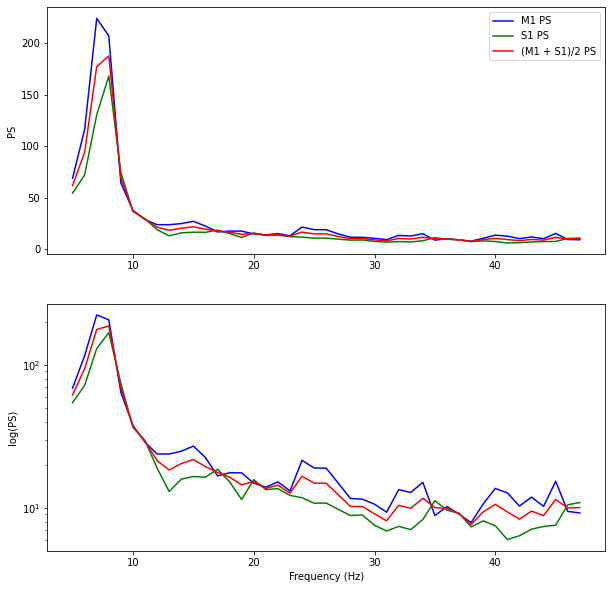

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].plot(f, psd_m1_targ, "b", label='M1 PS')
axes[0].plot(f, psd_s1_targ, "g", label='S1 PS')
axes[0].plot(f, psd_targ, "r", label='(M1 + S1)/2 PS')
axes[0].set_ylabel('PS')
axes[0].legend()
axes[1].semilogy(f, psd_m1_targ, "b", label='M1 PS')
axes[1].semilogy(f, psd_s1_targ, "g", label='S1 PS')
axes[1].semilogy(f, psd_targ, "r", label='(M1 + S1)/2 PS')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('log(PS)')


In [5]:
# # 1-node weights & delays
# weights = np.array([[1.]])
# delays = np.array([[10.]])

def prepare_params(g=0.0):
    
    # 2-nodes' weights & delays
    weights = np.array([[0.0, 1.0], [1.0, 0.0]])
    delays = np.array([[0.0, 10.0], [10.0, 0.0]])

    sc = 1/dt

    #g = 0.0  # 5.0
    I_o = -0.25

    stim_amp = 0.25
    i_e = -0.35 #  -1.0 # -0.75
    i_th = 0.5 + I_o
    wie = -3.0 # -4.0 # -2.0 #  -3.0 #
    wrtnth = -2.
    a_e = 0.9/sc # 0.3  # 0.9 #
    a_i = 0.9/sc # 0.5  # 0.9 #
    a_th = 0.25/sc # 0.2 # 0.25 #
    a_rtn = 0.25/sc # 0.2 # 0.25 #
        
    wee = 1.4 # 0.5 # 1.4 #
    wei = 1.4 # 1.0 # 1.4 #
    
    noise = 1e-4  # 1e-5

    ssX_params = dict(I_o=0.0,
                      wee = wee,
                      wei = wei,
                      wie = wie, 
                      wii = -0.5, # wie = -2.,wii = -0.5,
                      wertn = 0.6, weth = .6, wthi = 0.2, wthe = 1.65, wrtnth = wrtnth, wthrtn = 2.,
                      D_e = noise,D_i= noise,D_th = noise,D_rtn = noise,
                      T=int(sc*T), #T = 1024*4,# 20,
                      P=1,Q = 1, Dt = 0.001/sc,
                      dt = 0.1, gain = 20., threshold = 0., Pi = 3.14159,
                      g = g, # 10., # 1., #-0.9,
                      a_e = a_e, 
                      a_i = a_i, 
                      a_th=a_th, 
                      a_rtn=a_rtn, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
                      i_e = i_e,
                      i_i = -0.3, 
                      i_th = i_th, 
                      i_rtn = -0.8,
                      tau1 = sc*20.,
                      tau2 = sc*5., 
                      T_transient=int(sc*1000),
                      stim_amp=stim_amp, 
                      stim_freq=6.0, stim_type='sinewave', stim_pops=['th'],
                      weights=weights,
                      delays=delays,
                      K=weights.shape[0], #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
                      return_ts=True,
                      compute_connectivity=False ,
                      f=f
                     )#True) #False
    
    priors_params = dict(zip(["stim_amp", "i_e", "i_th", "wie", "wrtnth", "a_e", "a_i", "a_th", "a_rtn"], 
                             [stim_amp, i_e, i_th, wie, wrtnth, a_e, a_i, a_th, a_rtn]))
    
    return ssX_params, priors_params



In [6]:
def run_sim_for_sbi(priors, priors_params_names, params={}, return_ts=False):
    
    p = params.copy()
    
    for prior, pname in zip(priors, priors_params_names):  # 'noise'             
        try:
            numpy_prior = prior.numpy()
        except:
            numpy_prior = prior  
        if pname == 'noise':
            for noise in ['D_e', 'D_i', 'D_th','D_rtn']:
                p[noise] = 10**numpy_prior
        else:
            p[pname] = numpy_prior

    f = p.pop('f')
    
    res = run_net_sim(**p)
    
    # Periodogram PS:
    ssX_pps = res[2].copy()
    ssX_pps = ssX_pps['e'].loc[f[0]:f[-1] + 1.0].mean(axis=1)
    ssX_pps = np.interp(f, ssX_pps.index.values, ssX_pps.values)
    ssX_pps = ssX_pps / ssX_pps.sum()
    
    # Time series
    if return_ts:
        ssX_ts = res[0].copy()
        ssX_ts.columns= ssX_ts.columns.swaplevel(0)
        ssX_ts = ssX_ts[0]
        return  ssX_pps, ssX_ts 
    else:
        return  ssX_pps
    
    
def model_sbi_fit(iG):
    
    g = Gs[iG]
    
    ssX_params, priors_params = prepare_params(g)
    priors_params_names = list(priors_params.keys())
    run_sim_for_sbi_for_g = lambda priors: run_sim_for_sbi(priors, priors_params_names, 
                                                           params=ssX_params, return_ts=False)
    
    print("\n\nFitting for G = %g!\n" % g)
  #     # uniform priors: g
#     g_prior_min = [0.0]  # 
#     g_prior_max = [2.0]  # 
#     g_priors = utils.torchutils.BoxUniform(low=torch.as_tensor(g_prior_min), 
#                                          high=torch.as_tensor(g_prior_max))
    
    # normal priors:
    #             0.   1.     2.     3.     4.     5.    6.    7.      8.  
    #        stim_amp, i_e,   i_th,  wie,  wrtnth, a_e,  a_i,  a_th,  a_rtn
    prior_min = [0.1, -1.0,   0.0, -10.0, -5.0,   0.03, 0.03, 0.01,  0.01]  # 
    prior_max = [0.5,  0.0,   1.0,  0.0,   0.0,   0.15, 0.15, 0.05,  0.05]  # 
#     
    prior_loc = [0.25, -0.5,  0.5,  -5.0,  -2.5,  0.09, 0.09, 0.025, 0.025]  # 
    prior_sc =  [0.1,   0.25, 0.25,  2.5,   1.25, 0.03, 0.03, 0.005, 0.005]  # , 0.5
    
    n_priors = len(prior_min)
    
    priors_normal = torch.distributions.Normal(loc=torch.as_tensor(prior_loc), 
                                               scale=torch.as_tensor(prior_sc))
    
#     priors = torch.distributions.MultivariateNormal(loc=torch.as_tensor(prior_loc), 
#                                                     scale_tril=torch.diag(torch.as_tensor(prior_sc)))
    priors = torch.distributions.Independent(priors_normal, 1)
    
#     samples_fit
#     for iR in range(N_RUNS):
    tic = time.time()
    posterior = infer(run_sim_for_sbi_for_g, 
                      priors, method='SNPE', num_simulations=N_SIMULATIONS, num_workers=5)
    print("Done in %g sec!" % (time.time() - tic))
    
    print("\nSampling posterior...")

    samples_fit = posterior.sample((N_SAMPLES,), x=psd_targ_norm)  
    
    if os.path.isfile(filename):
        samples_fit_Gs = np.load(filename, allow_pickle=True).item()
    else:
        samples_fit_Gs = {}
    samples_fit_Gs[g] = {}
    samples_fit_Gs[g]['samples'] = samples_fit.numpy()
    samples_fit_Gs[g]['mean'] = samples_fit.mean(axis=0).numpy()
    np.save(filename, samples_fit_Gs, allow_pickle=True)
    
    print("\nPlotting posterior...")
    limits = []
    for pmin, pmax in zip(prior_min, prior_max):
        limits.append([pmin, pmax])
    fig, axes = analysis.pairplot(samples_fit,
                                  limits=limits,
                                  ticks=limits,
                                  figsize=(10,10),
                                  points=np.array(list(priors_params.values())),  # , -4
                                  points_offdiag={'markersize': 6},
                                  points_colors=['r']*n_priors);
                  
    print("\nSimulating with posterior means...")
    ssX_pps, ssX_ts = run_sim_for_sbi(samples_fit_Gs[g]['mean'], priors_params_names, 
                                      ssX_params, return_ts=True)
                    
    f = ssX_params['f']
    fig1, axes1 = plt.subplots(2, 1, figsize=(10, 10))
    # ssX_pps = ssX_pps / ssX_pps.sum()
    axes1[0].plot(f, ssX_pps, "b", label='Simulation')
    axes1[0].plot(f, psd_targ_norm, "r", label='Target')
    axes1[0].set_ylabel('PSD')
    axes1[0].legend()
    axes1[1].semilogy(f, ssX_pps, "b", label='Simulation')
    axes1[1].semilogy(f, psd_targ_norm, "r", label='Target')
    axes1[1].set_xlabel('Frequency (Hz)')
    axes1[1].set_ylabel('log(PSD)')
    
    time_vals = ssX_ts['e'].index.values
    fig2, axes2 = plt.subplots(4, 1, figsize=(20, 10))
    ssX_ts['e'].plot(ax=axes2[0])
    me = ssX_ts['e'].mean()
    axes2[0].plot([time_vals[0], time_vals[-1]], [me]*2, 'r')
    axes2[0].set_title('e\nm=%g' % me)
    ssX_ts['i'].plot(ax=axes2[1])
    mi = ssX_ts['i'].mean()
    axes2[1].plot([time_vals[0], time_vals[-1]], [mi]*2, 'r')
    axes2[1].set_title('i\nm=%g' % mi)
    ssX_ts['th'].plot(ax=axes2[2])
    mth = ssX_ts['th'].mean()
    axes2[2].plot([time_vals[0], time_vals[-1]], [mth]*2, 'r')
    axes2[2].set_title('th\nm=%g' % mth)
    ssX_ts['rtn'].plot(ax=axes2[3])
    mrtn = ssX_ts['rtn'].mean()
    axes2[3].plot([time_vals[0], time_vals[-1]], [mrtn]*2, 'r')
    axes2[3].set_title('rtn\nm=%g' % mrtn)
    axes2[3].set_xlabel('Time (ms)')
    fig2.tight_layout()
                                  
    return samples_fit_Gs, ((fig, axes), (fig1, axes1), (fig2, axes2))
    

In [7]:
samples = []
figs = []




Fitting for G = 0!



Running 5 simulations in 5 batches.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 109 epochs.Done in 25.1224 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


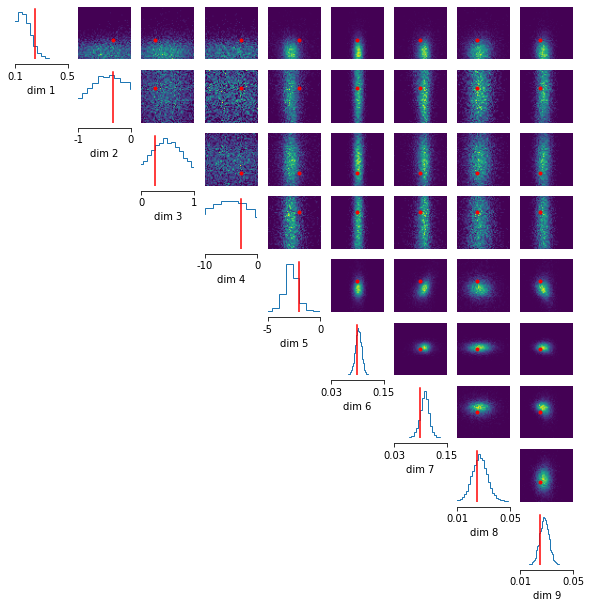

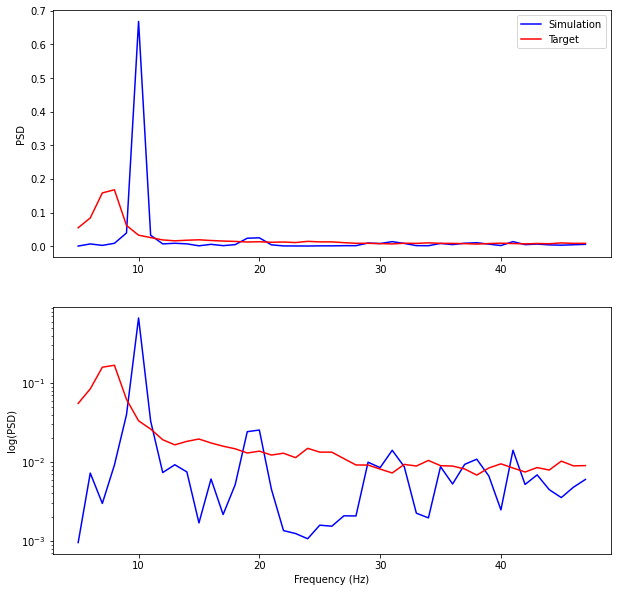

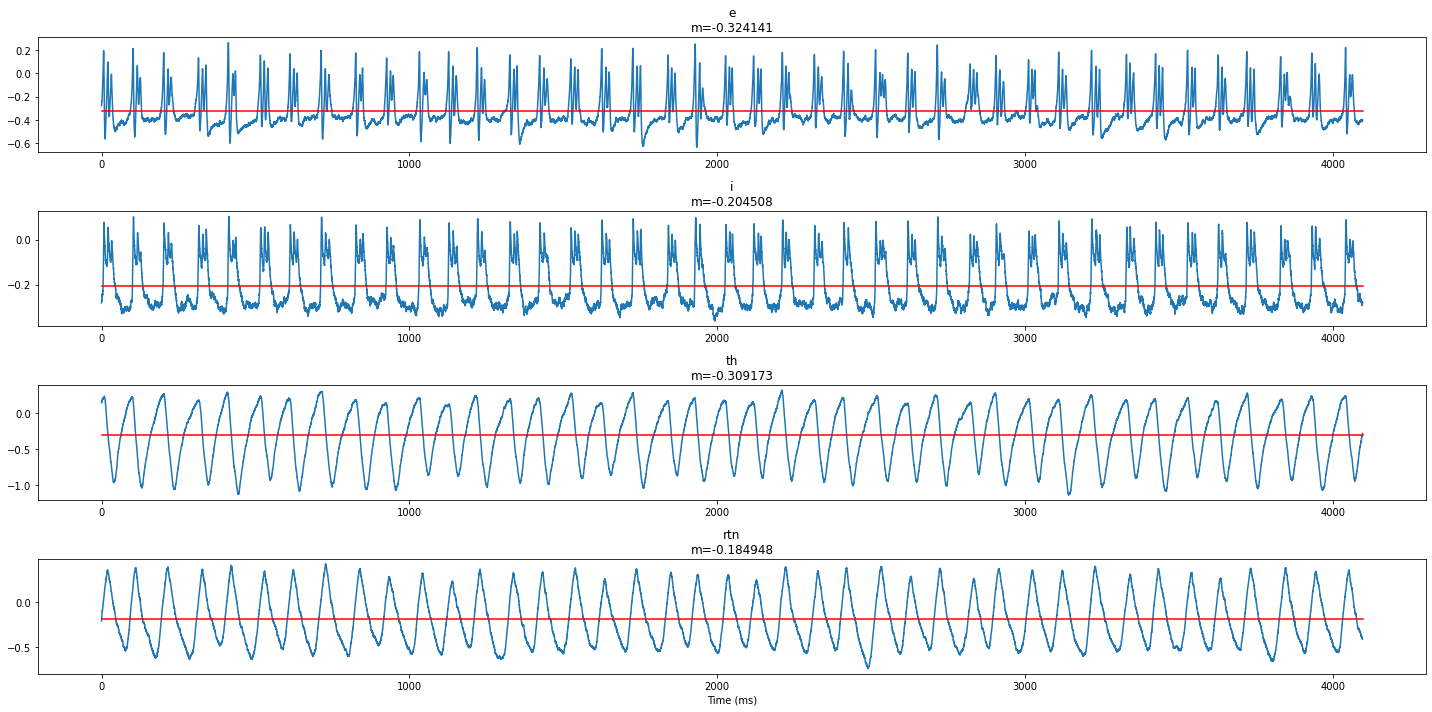

In [8]:
samples_fit_Gs, figaxes = model_sbi_fit(0)
samples.append(samples_fit_Gs)
figs.append(figaxes)


In [11]:
samples_fit_Gs[0.0]['samples']

array([[ 0.12410216, -0.04298941,  0.83214134, ...,  0.10873547,
         0.02208718,  0.02428673],
       [ 0.24671827, -0.7681513 ,  0.46858174, ...,  0.10684721,
         0.01905285,  0.02570847],
       [ 0.15010396, -0.09938814,  0.6471888 , ...,  0.11331654,
         0.02195725,  0.0239632 ],
       ...,
       [ 0.08084761, -0.8201449 , -0.19596481, ...,  0.12755325,
         0.02937664,  0.03504815],
       [ 0.13163643, -1.0792029 ,  0.9871015 , ...,  0.10423992,
         0.0283276 ,  0.02693144],
       [ 0.11788651, -1.4748721 ,  0.54514146, ...,  0.09274597,
         0.03131254,  0.02918819]], dtype=float32)



Fitting for G = 0.5!



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

../ctwc/ctwc_model_DP.py:102: RuntimeWarning: overflow encountered in exp
  output= 1./(1.+exp(-gain*(u-threshold)));
../ctwc/ctwc_model_DP.py:102: RuntimeWarning: overflow encountered in exp
  output= 1./(1.+exp(-gain*(u-threshold)));


Neural network successfully converged after 44 epochs.
Done in 1128.28 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


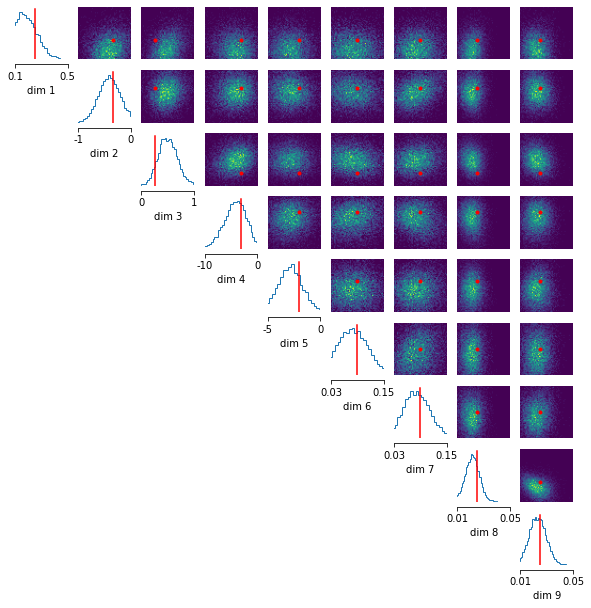

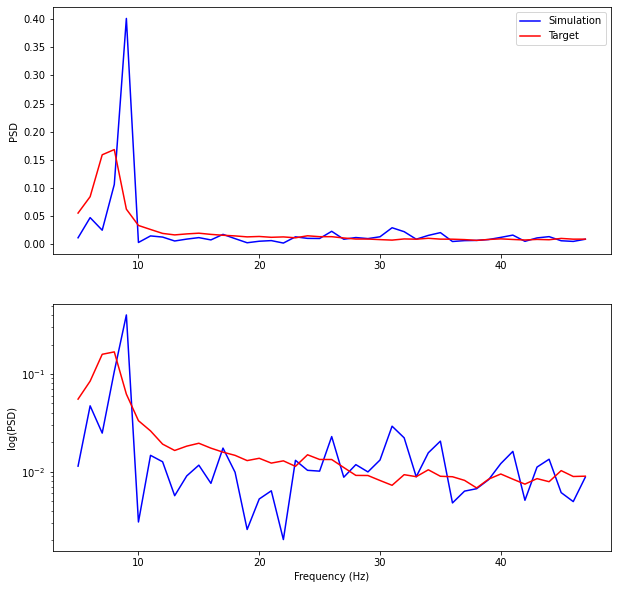

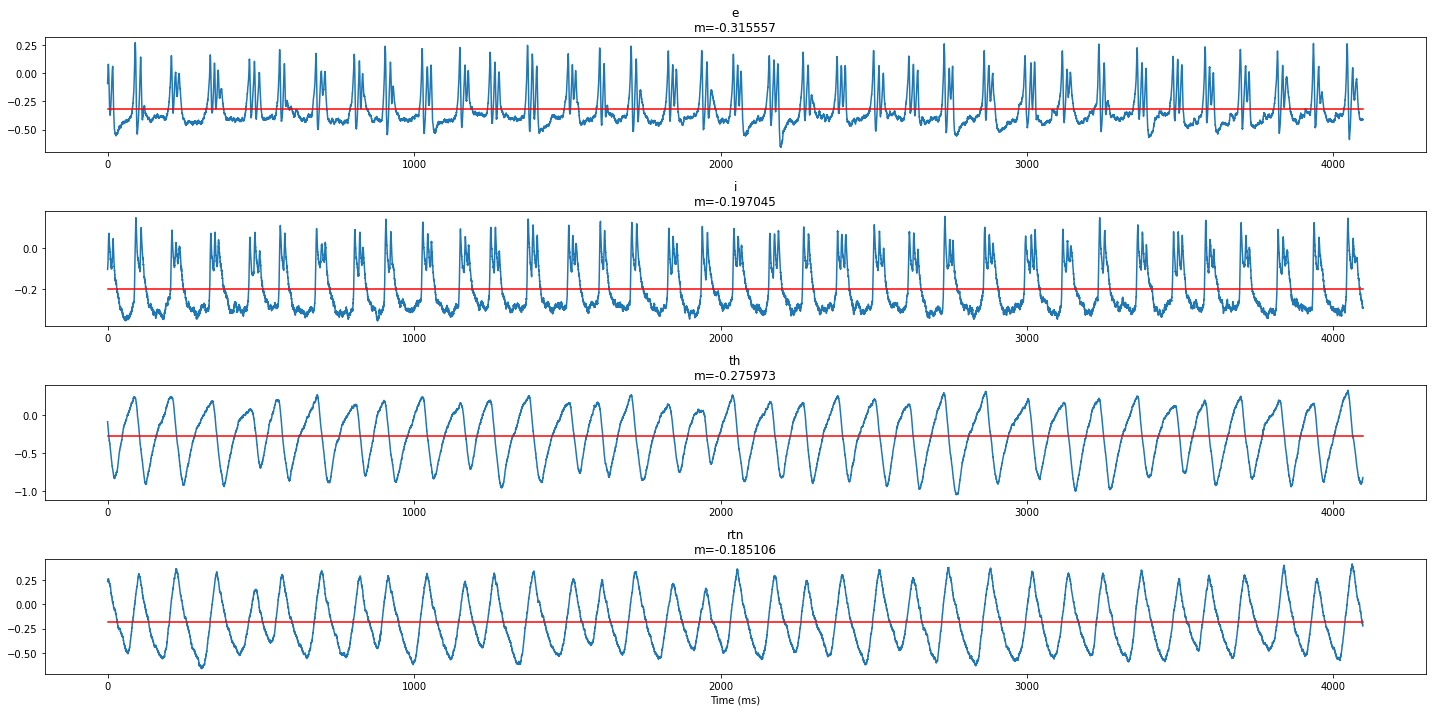

In [9]:
samples_fit_Gs, figaxes = model_sbi_fit(1)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 1!



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 43 epochs.
Done in 1146.53 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


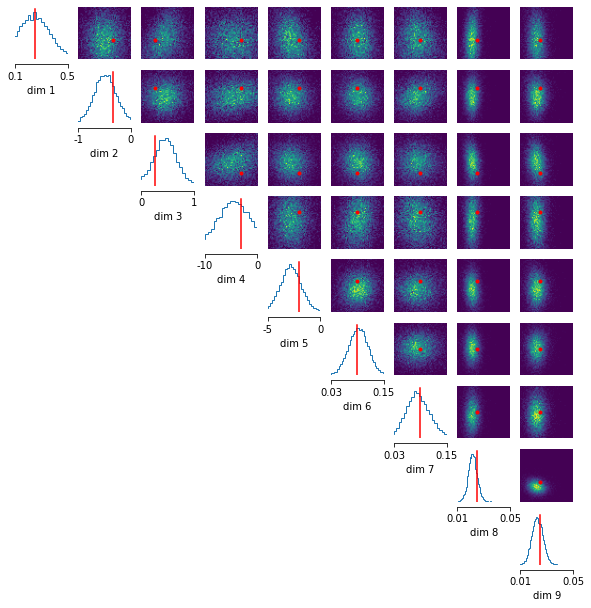

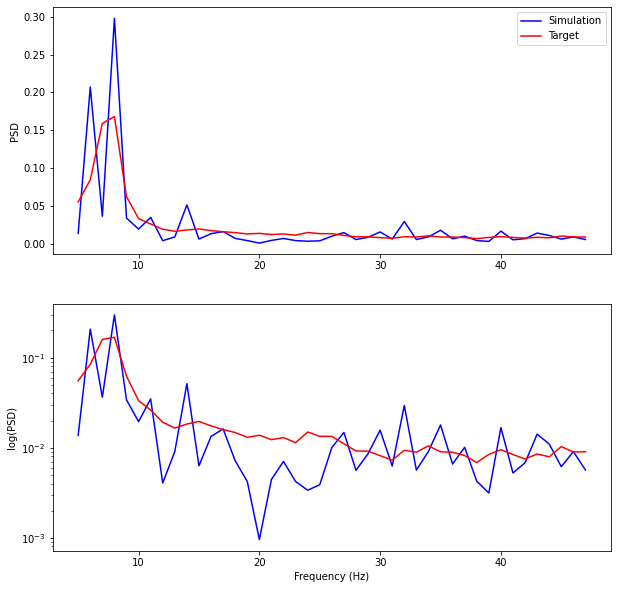

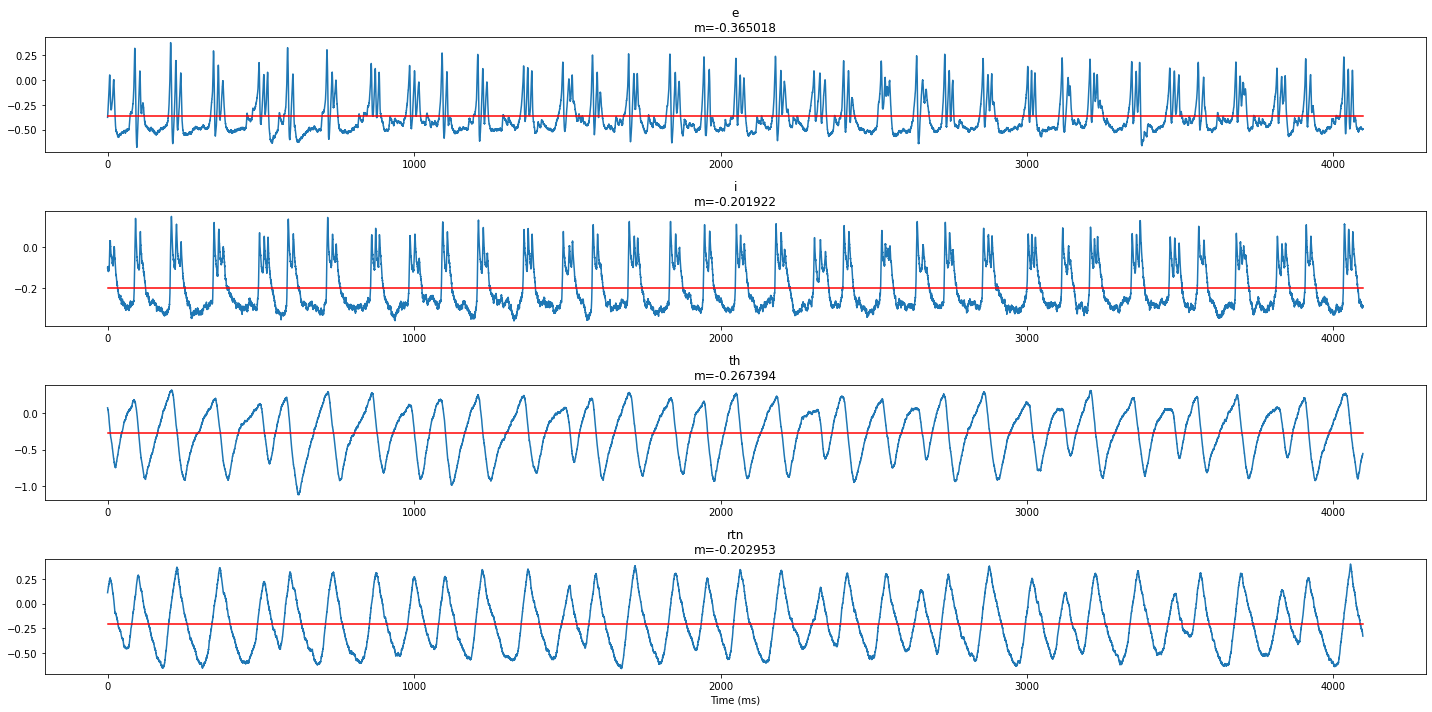

In [10]:
samples_fit_Gs, figaxes = model_sbi_fit(2)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 1.5!



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

../ctwc/ctwc_model_DP.py:102: RuntimeWarning: overflow encountered in exp
  output= 1./(1.+exp(-gain*(u-threshold)));
../ctwc/ctwc_model_DP.py:102: RuntimeWarning: overflow encountered in exp
  output= 1./(1.+exp(-gain*(u-threshold)));
../ctwc/ctwc_model_DP.py:102: RuntimeWarning: overflow encountered in exp
  output= 1./(1.+exp(-gain*(u-threshold)));


Neural network successfully converged after 43 epochs.
Done in 1082.12 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


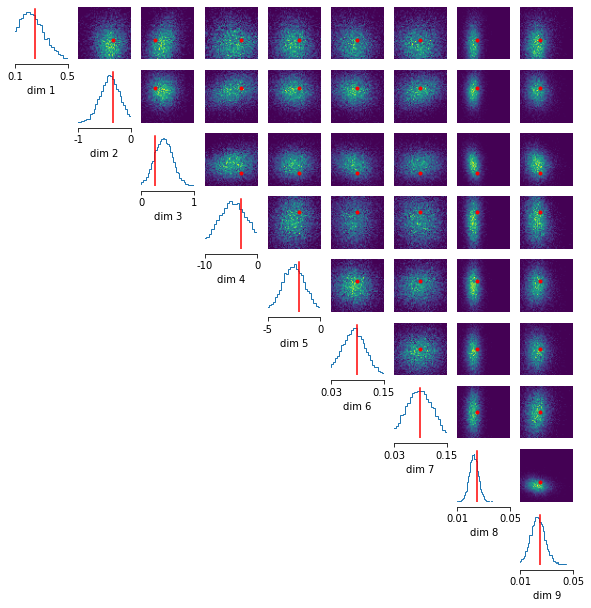

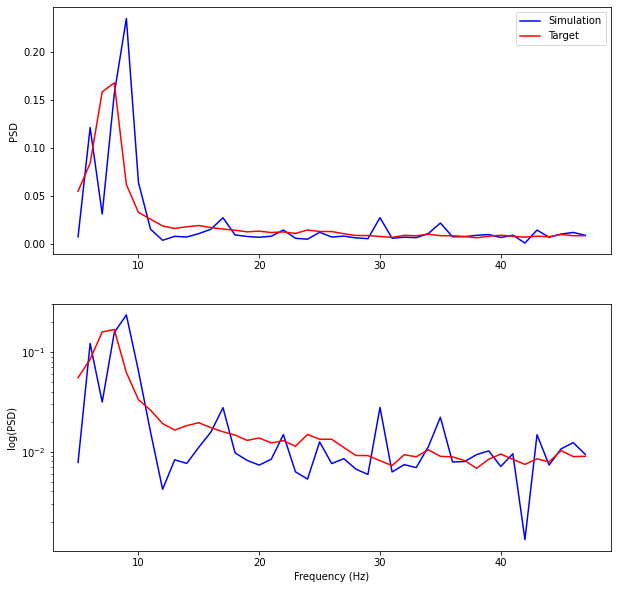

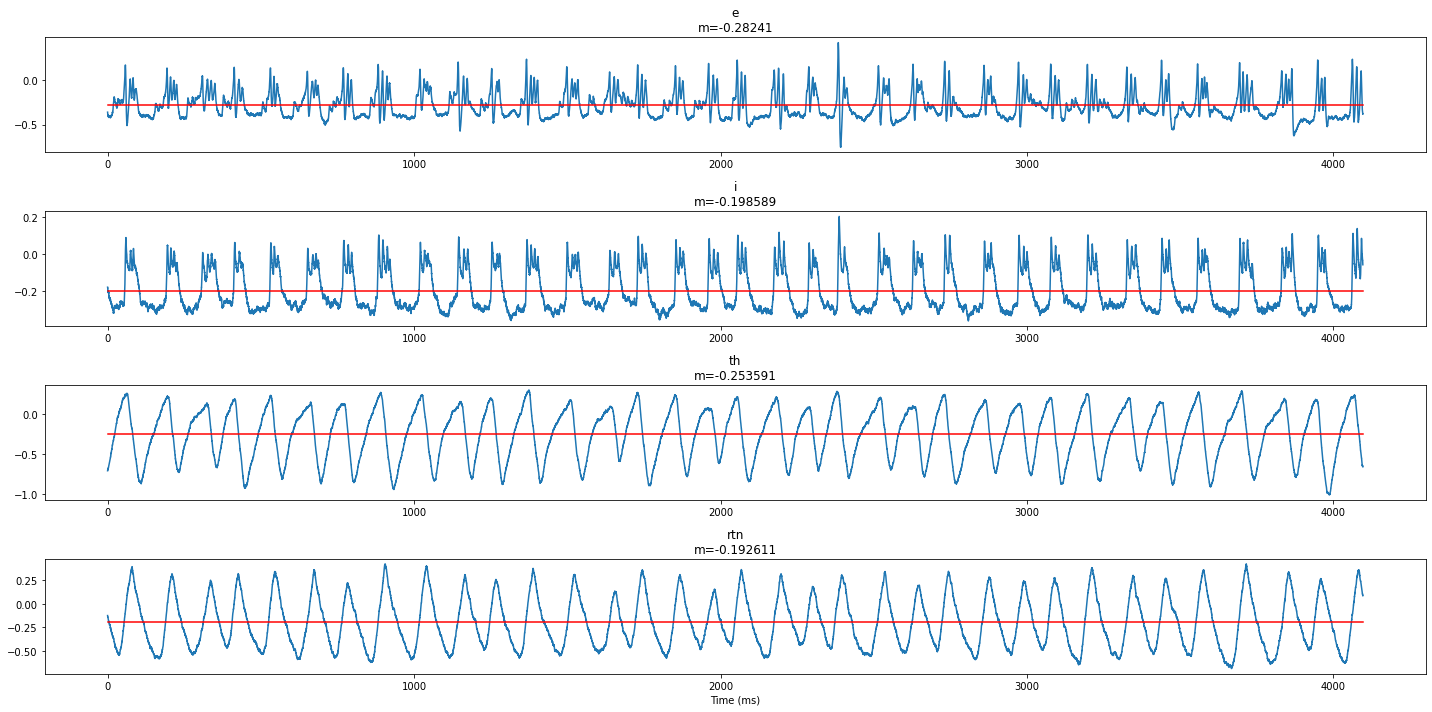

In [11]:
samples_fit_Gs, figaxes = model_sbi_fit(3)
samples.append(samples_fit_Gs)
figs.append(figaxes)




Fitting for G = 2!



Running 500 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]

../ctwc/ctwc_model_DP.py:102: RuntimeWarning: overflow encountered in exp
  output= 1./(1.+exp(-gain*(u-threshold)));


Neural network successfully converged after 39 epochs.
Done in 1033.33 sec!

Sampling posterior...


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Plotting posterior...

Simulating with posterior means...


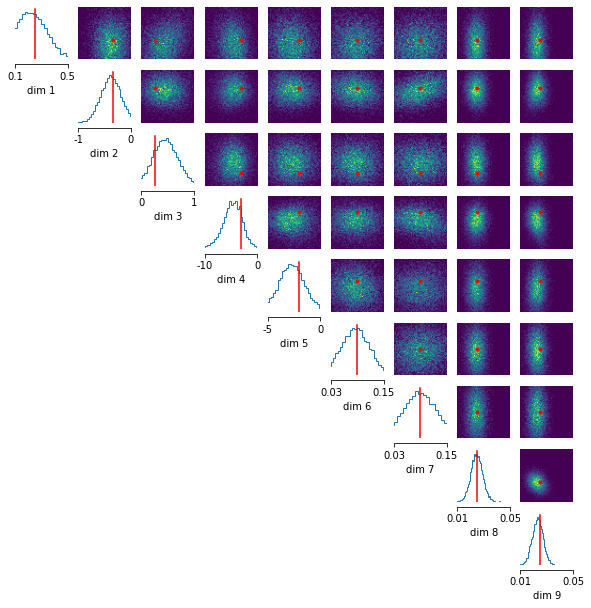

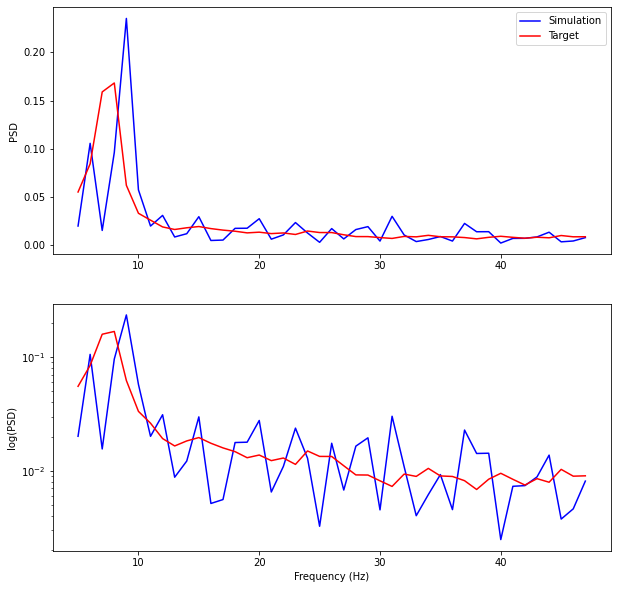

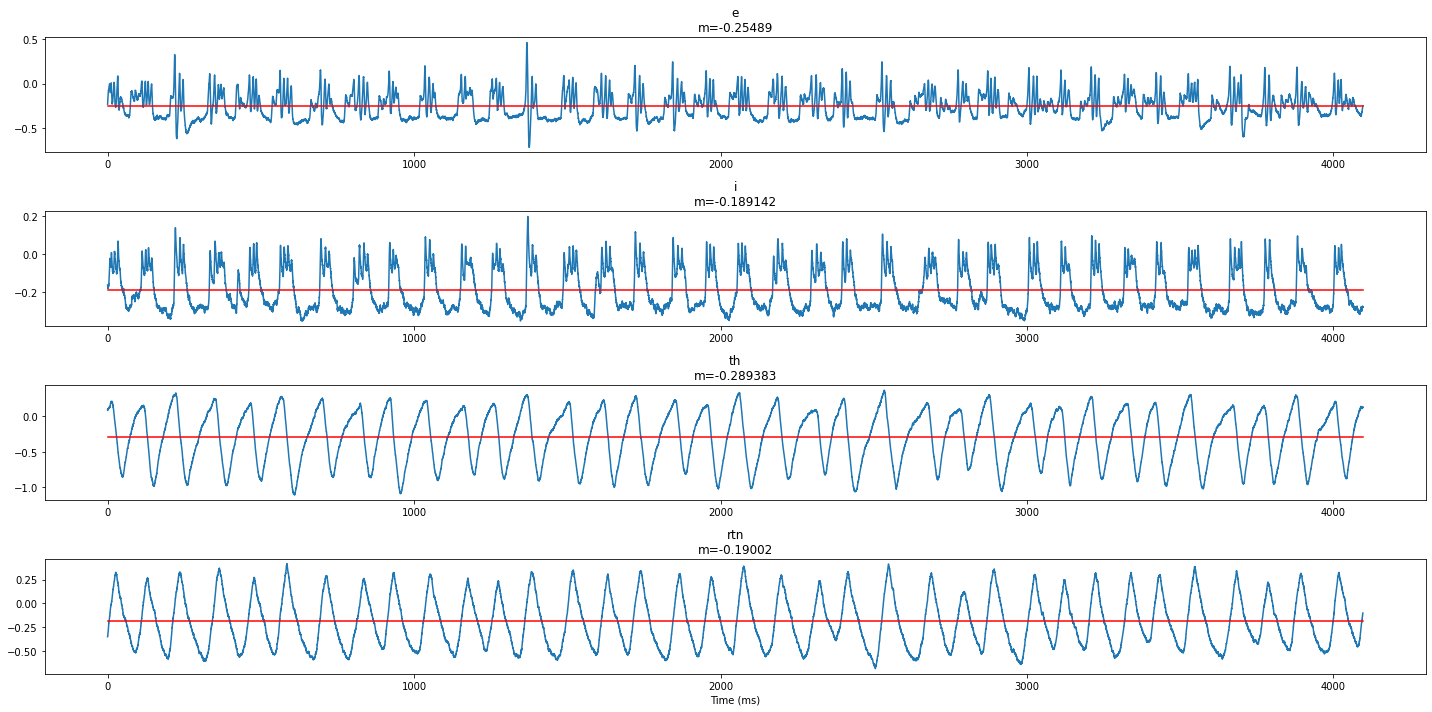

In [12]:
samples_fit_Gs, figaxes = model_sbi_fit(4)
samples.append(samples_fit_Gs)
figs.append(figaxes)


In [13]:
samples

[{0.0: {'samples': array([[ 0.10927369, -0.3426412 ,  0.34733537, ...,  0.10282728,
            0.02064036,  0.02969598],
          [ 0.20960493, -0.42694256,  0.25742033, ...,  0.07791182,
            0.02042711,  0.02436148],
          [ 0.1672551 , -0.3635231 ,  0.4788563 , ...,  0.10472974,
            0.01553258,  0.01735398],
          ...,
          [ 0.19116439, -0.4848846 ,  0.49766117, ...,  0.09282698,
            0.022594  ,  0.0148845 ],
          [ 0.3229579 , -0.12777843,  0.5943306 , ...,  0.11414918,
            0.02121992,  0.0195158 ],
          [ 0.33574173, -0.4970712 ,  0.9056004 , ...,  0.08872706,
            0.02359321,  0.02230378]], dtype=float32),
   'mean': array([ 0.22511181, -0.41745773,  0.39297974, -4.076854  , -2.3611825 ,
           0.08280731,  0.08907809,  0.02296674,  0.02200952], dtype=float32)}},
 {0.0: {'samples': array([[ 0.10927369, -0.3426412 ,  0.34733537, ...,  0.10282728,
            0.02064036,  0.02969598],
          [ 0.20960493, -0.426